In [1]:
import numpy as np
import pickle
import matplotlib as mpl
mpl.use('TkAgg')
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
csfont = {'fontname':'DejaVu Serif'}
ticklabelsize = 10
plt.rcParams['xtick.labelsize'] = ticklabelsize
plt.rcParams['ytick.labelsize'] = ticklabelsize
%matplotlib notebook
import sys, os
from azav_util import plot_azav
#from common import get_widest_range_file, strip_dirname, get_dict, rms
#from derivs import drad, dth
from common import *
#from get_parameter import get_parameter

In [2]:
# Make function to flip array with AZ array with either even or odd symmetry
def symmetrize_field(field, sym):
    nt, nr = np.shape(field)
    new_field = np.copy(field)
    # "Fold" the field in half
       
    # Field is ordered from theta=pi (south pole) to theta=0 (north pole)
    # Average the Northern and Southern hemispheres together (must flip 
    # the Southern hemisphere with respect to latitude, then add or subtract it
    if sym=='even':
        new_field = 0.5*(new_field + np.flip(new_field, axis=0))
    elif sym=='odd':
        new_field = 0.5*(new_field - np.flip(new_field, axis=0))
  
    return new_field

In [3]:
# Get Rachel's solar data
di = get_dict('/mizar/loma3853/fixedflux/paperplots/gongdata/avgong.pkl')
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s
rsun = 6.957e10
rr = di['rr']*rsun
tt = di['tt']
cost_2d = di['cost_2d']
sint_2d = di['sint_2d']
rr_2d = di['rr_2d']*rsun
cost = np.cos(tt)
sint = np.sin(tt)

In [4]:
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10, 3.35640465e+10, 3.07658715e+10, 2.78460882e+10,
       2.48004527e+10, 2.16318175e+10, 1.83538183e+10, 1.50028401e+10,
       1.16941604e+10, 8.69896323e+09, 6.25519871e+09, 4.31282518e+09,
       2.70508335e+09, 1.29888581e+09, 0.00000000e+00])

In [5]:
# Let's remove the r-values lower than a cutoff
#ircut = np.argmin(np.abs(rr - 4.176e10))
ircut = np.argmin(np.abs(rr - 3.4e10))
rr = rr[:ircut]
cost_2d = cost_2d[:, :ircut]
sint_2d = sint_2d[:, :ircut]
rr_2d = rr_2d[:, :ircut]
Om = Om[:, :ircut]
nr = len(rr)
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10])

In [6]:
# And the r-values over 6.93e10 (note that at 6.94e10, my quartic CZ-RZ reference state gives nans...)
ircut = np.argmin(np.abs(rr - 6.93e10))
rr = rr[ircut+1:]
cost_2d = cost_2d[:, ircut+1:]
sint_2d = sint_2d[:, ircut+1:]
rr_2d = rr_2d[:, ircut+1:]
Om = Om[:, ircut+1:]
nr = len(rr)

In [7]:
dOmdr = drad(Om, rr)
dOmdt = dth(Om, tt)
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt/rr_2d
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt/rr_2d

In [8]:
# Use a standard custom reference state (will be wrong below CZ) to get radial profiles of
# rhobar and g for Rachel's data
#from get_eq import get_eq
eq = get_eq('.', fname='custom_reference_binary')
rr_ref = eq.radius
rho_ref = eq.density
g_ref = eq.gravity
np.min(rho_ref) # check this is just super low (not nan)

nan

In [9]:
len(tt)

49

In [10]:
from scipy.interpolate import interp1d
# first interpolate density
f = interp1d(rr_ref, rho_ref)
rho = f(rr)

# then interpolate gravity
f = interp1d(rr_ref, g_ref)
g = f(rr)

<IPython.core.display.Javascript object>


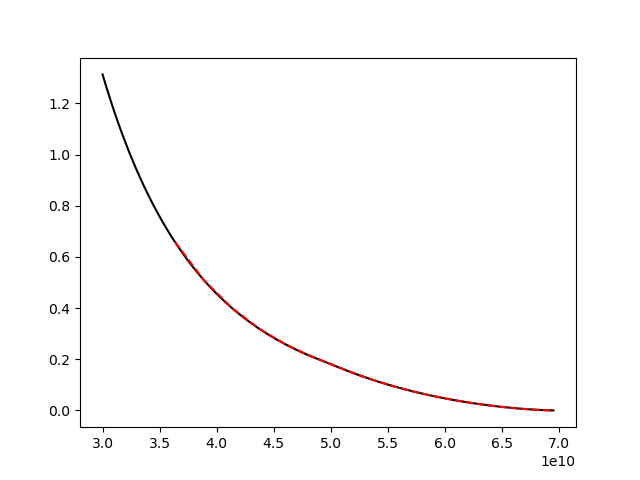

In [11]:
# Plot the interpolation to make sure it worked
plt.figure()
plt.plot(rr_ref, rho_ref, 'k')
plt.plot(rr, rho, 'r--')

<IPython.core.display.Javascript object>


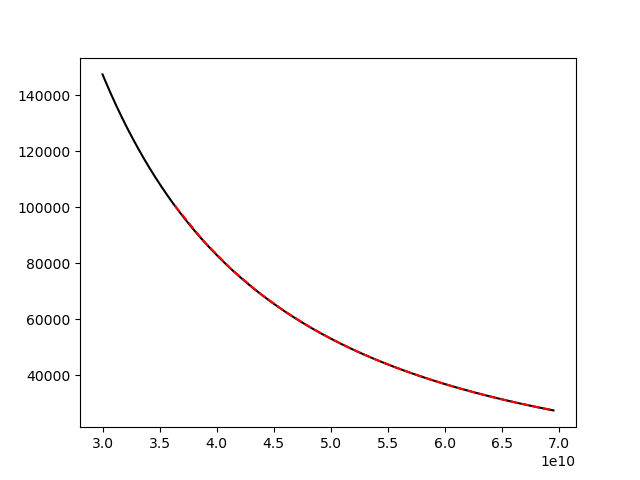

In [12]:
plt.figure()
plt.plot(rr_ref, g_ref, 'k')
plt.plot(rr, g, 'r--')
plt.show()

In [13]:
eq.pressure

array([           nan,            nan,            nan, ...,
       8.56404332e+14, 8.57529685e+14, 8.58656717e+14])

<IPython.core.display.Javascript object>


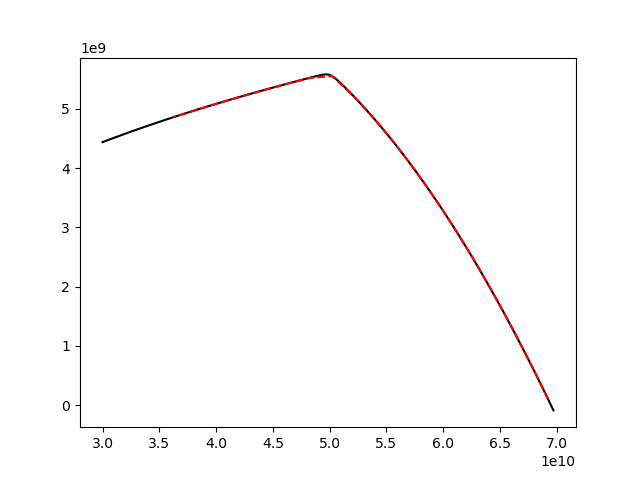

In [14]:
# Sweet...also interpolate pressure, temp, and define cP, pressure scale height
cp = 3.5e8
prs_ref = eq.pressure
dlnrho_ref = eq.dlnrho
dlnT_ref = eq.dlnT
dlnP_ref = dlnrho_ref + dlnT_ref

f = interp1d(rr_ref, prs_ref)
prs = f(rr)
T_ref = eq.temperature
f = interp1d(rr_ref, T_ref)
T = f(rr)

# get pressure scale height
Hp_ref = -1./dlnP_ref
f = interp1d(rr_ref, Hp_ref)
Hp = f(rr)
plt.figure()
plt.plot(rr_ref, Hp_ref, 'k')
plt.plot(rr, Hp, 'r--')

In [15]:
# Solve (non-D) thermal wind equations
dPdt = (rr_2d**2)*Om**2*sint_2d*cost_2d/g/Hp
dSdt = 2*Om*rr_2d**2*sint_2d*dOmdz/g

In [16]:
tt

array([1.5708   , 1.53807  , 1.50535  , 1.47262  , 1.4399   , 1.40717  ,
       1.37445  , 1.34172  , 1.309    , 1.27627  , 1.24355  , 1.21082  ,
       1.1781   , 1.14537  , 1.11265  , 1.07992  , 1.0472   , 1.01447  ,
       0.981748 , 0.949023 , 0.916298 , 0.883573 , 0.850848 , 0.818123 ,
       0.785398 , 0.752673 , 0.719948 , 0.687223 , 0.654499 , 0.621774 ,
       0.589049 , 0.556324 , 0.523599 , 0.490874 , 0.458149 , 0.425424 ,
       0.392699 , 0.359974 , 0.327249 , 0.294524 , 0.261799 , 0.229074 ,
       0.19635  , 0.163625 , 0.1309   , 0.0981748, 0.0654498, 0.0327249,
       0.       ])

In [17]:
np.diff(tt)

array([-0.03273  , -0.03272  , -0.03273  , -0.03272  , -0.03273  ,
       -0.03272  , -0.03273  , -0.03272  , -0.03273  , -0.03272  ,
       -0.03273  , -0.03272  , -0.03273  , -0.03272  , -0.03273  ,
       -0.03272  , -0.03273  , -0.032722 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032725 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032724 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032725 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032725 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032724 , -0.032725 , -0.032725 , -0.0327252,
       -0.032725 , -0.0327249, -0.0327249])

In [18]:
# The latitudes are ~linearly spaced (thanks Rachel!) Let's do Simpson integration from the equator
# to get S and P
from scipy.integrate import simps
nt = len(tt)
P_dev = np.zeros((nt, nr))
for ir in range(nr):
    dPdt_loc = dPdt[:, ir]
    for it in range(nt):
        P_dev[it, ir] = simps(dPdt_loc[:it+1], tt[:it+1])

In [19]:
# Integrate S
S_dev = np.zeros((nt, nr))
for ir in range(nr):
    dSdt_loc = dSdt[:, ir]
    for it in range(nt):
        S_dev[it, ir] = simps(dSdt_loc[:it+1], tt[:it+1])

In [20]:
# Get the temperature two
gam = 5./3.
T_dev = S_dev + (1. - 1./gam)*P_dev

In [21]:
# Let's extend these arrays to the Southern hemisphere
# (keeping them even about the equator)
tt2 = np.zeros(2*nt)
tt2[:nt] = np.pi - tt[::-1]
tt2[nt:] = np.copy(tt)

cost2 = np.cos(tt2)
sint2 = np.sin(tt2)

T_dev2 = np.zeros((2*nt, nr))
T_dev2[:nt, :] = np.copy(T_dev[::-1, :])
T_dev2[nt:, :] = np.copy(T_dev)

S_dev2 = np.zeros((2*nt, nr))
S_dev2[:nt, :] = np.copy(S_dev[::-1, :])
S_dev2[nt:, :] = np.copy(S_dev)

P_dev2 = np.zeros((2*nt, nr))
P_dev2[:nt, :] = np.copy(P_dev[::-1, :])
P_dev2[nt:, :] = np.copy(P_dev)

In [22]:
# get dimensional results too
T_dev_dim = T_dev2*T
S_dev_dim = S_dev2*cp
P_dev_dim = P_dev2*prs

In [45]:
# Let's plot the result!
def plot_azav_half(fig, axis, field, radius, costheta, sintheta,
        mycmap=plt.cm.RdYlBu_r, units = r'$\rm{m}\ \rm{s}^{-1}$', 
        nlevs = 10, minmax=None, 
        plotcontours=True, plotfield=True, plotlatlines=False,
        norm=None, levels=None, fsize=8, odd=True):
    '''Takes a figure with a subplot (axis) of aspect ratio 1x1 and adds
    a plot of the upper meridional plane to the axis, with colorbar in the "cavity"
    of the meridional plane'''

    # First, "fold" the field in half, using odd symmetry
    # Please don't try this with odd N_theta!
    nt = len(costheta)
    it_half = int(nt/2)
    
    # Field is ordered from theta=pi (south pole) to theta=0 (north pole)
    # Average the Northern and Southern hemispheres together(must flip the Southern hemisphere)
    # Also add the negative of the southern hemisphere, since antisymmetric
    if odd:
        field = 0.5*(field[it_half:, :] - np.flip(field[:it_half, :], axis=0))
    else:
        field = 0.5*(field[it_half:, :] + np.flip(field[:it_half, :], axis=0))
    costheta = costheta[it_half:]
    sintheta = sintheta[it_half:]
    
    if minmax is None:
        # By default, do the max/min values of the field not including lats > 75
        it_75 = np.argmin(np.abs(costheta - np.cos(np.pi/12)))
        mini, maxi = np.min(field[:it_75, :]), np.max(field[:it_75,:])
        maxabs = max(np.abs(mini), np.abs(maxi))
        mini, maxi = -maxabs, maxabs
    else:
        mini, maxi = minmax

    # Get the exponent to use for scientific notation
    extent = np.max((np.abs(mini), np.abs(maxi)))
    exp = int(np.floor(np.log10(extent)))
    divisor = 10**exp
    
    # Normalize field by divisor
    field /= divisor
    mini /= divisor
    maxi /= divisor
   
    # Get the position of the axes on the figure
    pos = axis.get_position().get_points()
    axis_left, axis_bottom = pos[0]
    axis_right, axis_top = pos[1]
    axis_width = axis_right - axis_left
    axis_height = axis_top - axis_bottom
    axis_aspect = axis_height/axis_width
   
    # Set the colorbar axis to be in the "cavity" of the meridional plane
    # The colorbar height is set by making sure it "fits" in the cavity
    chi = np.min(radius)/np.max(radius) # aspect ratio of the shell
    cavity_height = axis_height*chi
    cbaxis_aspect = 10
    cbaxis_height = 0.7*cavity_height
    cbaxis_width = cbaxis_height/cbaxis_aspect / axis_aspect
    
    cbaxis_left = axis_left + 0.1*axis_width
    cbaxis_bottom = axis_bottom + 0.1*axis_height
    
    #Modified version of Antoine Strukarek's routine
    r = radius/np.max(radius)
    n_r = len(r)
    n_t = it_half
    rtmp = r.reshape(1, n_r)
    cthtmp = costheta.reshape(n_t, 1)
    sthtmp = sintheta.reshape(n_t, 1)
    xr = np.dot(cthtmp, rtmp)
    yr = np.dot(sthtmp, rtmp)
    
    # Specify linewidths to be used in the meridional plane, one for the 
    # boundary (lw) and one for the contours (contour_lw)
    lw = 1
    contour_lw = .2
    
    if (plotfield):
        plt.sca(axis)
        plt.pcolormesh(yr, xr, field, vmin=mini, vmax=maxi,\
                cmap=mycmap, norm=norm, shading='auto')
     
        cbaxes = fig.add_axes([cbaxis_left, cbaxis_bottom,\
                       cbaxis_width, cbaxis_height])
        cbar = plt.colorbar(cax=cbaxes)

        #fsize = 8 # fontsize for colorbar ticks and labels
        cbaxes.tick_params(labelsize=fsize)
#        cbar.set_label(units, rotation=270, labelpad=25, fontsize=18)
        cbar.ax.tick_params(labelsize=fsize)   #font size for the ticks
        ticks = np.array([mini, 0, maxi])
        ticklabels = []
        for i in range(len(ticks)):
            ticklabels.append(str(round(ticks[i],1)))
        ticks = np.array(ticks)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(ticklabels)

        # Put the units and exponent to left of colorbar
        cbar_label = (r'$\times10^{%i}\ $' %exp) + units
        fig.text(cbaxis_left - 0.3*cbaxis_width, cbaxis_bottom + cbaxis_height/2, cbar_label,\
            ha='right', va='center', rotation=90, fontsize=fsize)

    # Plot the boundary of the meridional plane
    plt.sca(axis)
    plt.plot(r[0]*sintheta, r[0]*costheta, 'k', linewidth=lw) # outer boundary
    plt.plot(r[n_r-1]*sintheta, r[n_r-1]*costheta, 'k', linewidth=lw) # inner boundary
    plt.plot([0,0], [r[n_r-1], r[0]], 'k', linewidth=lw) # polar "edge"
    plt.plot([r[n_r-1], r[0]], [0,0], 'k', linewidth=lw) # equatorial "edge"

    # Plot latitude lines, if desired
    if plotlatlines:
        lats_to_plot = np.arange(-75, 90, 15)
        for lat in lats_to_plot:
            theta_val = (90 - lat)*np.pi/180
            x_in, z_in = r[-1]*np.sin(theta_val), r[-1]*np.cos(theta_val)
            x_out, z_out = r[0]*np.sin(theta_val), r[0]*np.cos(theta_val)
            plt.sca(axis)
            plt.plot([x_in, x_out], [z_in, z_out], 'k',\
                    linewidth=contour_lw)


    # Set axis ranges to be just outside the boundary lines
    lilbit = 0.01
    axis.set_xlim((-lilbit, 1 + lilbit))
    axis.set_ylim((-lilbit, 1 + lilbit))
    axis.axis('off') 

    if (plotcontours):
        if levels is None:
            levs=mini+np.linspace(1,nlevs,nlevs)/float(nlevs)*(maxi-mini)
        else: # the caller specified specific contour levels to plot!
            levs=np.array(levels)
        plt.contour(yr,xr,field,colors='k',levels=levs, linewidths=contour_lw)

<IPython.core.display.Javascript object>


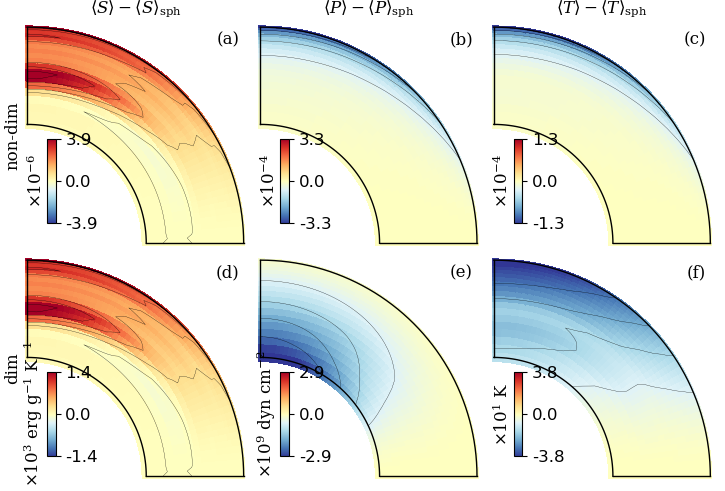

/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explic

In [46]:
# Make figure
fig_width_inches = 7.25
margin_inches = 1./8.
margin_top_inches = 1./4.
margin_left_inches = 1./4.
subplot_width_inches = (fig_width_inches - 3*margin_inches - margin_left_inches)/3
subplot_height_inches = subplot_width_inches
fig_height_inches = 2*(subplot_height_inches + margin_inches) + margin_top_inches

fig_aspect = fig_height_inches/fig_width_inches
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches

subplot_width = subplot_width_inches/fig_width_inches
subplot_height = subplot_height_inches/fig_height_inches
   
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

ax1 = fig.add_axes((margin_left, 1 - margin_top - subplot_height, subplot_width, subplot_height))   
ax2 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
                    1 - margin_top - subplot_height, subplot_width, subplot_height))
ax3 = fig.add_axes((margin_left + 2*(subplot_width + margin_x),\
                    1 - margin_top - subplot_height, subplot_width, subplot_height))

ax4 = fig.add_axes((margin_left, margin_y, subplot_width, subplot_height))   
ax5 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
                    margin_y, subplot_width, subplot_height))
ax6 = fig.add_axes((margin_left + 2*(subplot_width + margin_x),\
                    margin_y, subplot_width, subplot_height))

units_s = r'$\rm{erg\ g^{-1}\ K^{-1}}$'
units_p = r'$\rm{dyn\ cm^{-2}}$'
units_T = r'$\rm{K}$'

az_fs = 12
# Ignore part of NSSL...things will go crazy
#rcut = rr[0]
rcut = 0.95*6.96e10
ircut = np.argmin(np.abs(rr - rcut))
#ircut = 0
minmax = None
#minmax=(-2.5e3, 2.5e3)
plot_azav_half (fig, ax1, S_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units='', minmax=minmax, odd=False)
plot_azav_half (fig, ax2, P_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units='', minmax=minmax, odd=False)
plot_azav_half (fig, ax3, T_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units='', minmax=minmax, odd=False)

#nond_max = 1.5e-5
#factor = 1 - 1/gam
# minmax=(-nond_max*factor,nond_max*factor)
plot_azav_half (fig, ax4, S_dev_dim[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units=units_s, minmax=minmax, odd=False)
plot_azav_half (fig, ax5, P_dev_dim[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units=units_p, minmax=minmax, odd=False)
plot_azav_half (fig, ax6, T_dev_dim[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units=units_T, minmax=minmax, odd=False)

# Label the plots with (a), (b), ...
fs = 12
fig.text(margin_left + subplot_width - margin_x/2, 1 - margin_top - margin_y/2, '(a)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 1*(margin_x + subplot_width),\
         1 - margin_top - margin_y/2, '(b)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 2*(margin_x + subplot_width),\
         1 - margin_top - margin_y/2, '(c)',\
         va='top', ha='right', **csfont, fontsize=fs)

fig.text(margin_left + subplot_width - margin_x/2, margin_y + subplot_height - margin_y/2, '(d)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 1*(margin_x + subplot_width),\
          margin_y + subplot_height - margin_y/2, '(e)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 2*(margin_x + subplot_width),\
          margin_y + subplot_height - margin_y/2, '(f)',\
         va='top', ha='right', **csfont, fontsize=fs)

# Label the top with the thermal variable
fig.text(margin_left + 0.5*subplot_width, 1 - margin_top + margin_y/2,\
         r'$\langle S\rangle - \langle S\rangle_{\rm{sph}}$', fontsize=fs, **csfont, ha='center', va='bottom')
fig.text(margin_left + 0.5*subplot_width + 1*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         r'$\langle P\rangle - \langle P\rangle_{\rm{sph}}$', fontsize=fs, **csfont, ha='center', va='bottom')
fig.text(margin_left + 0.5*subplot_width + 2*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         r'$\langle T\rangle - \langle T\rangle_{\rm{sph}}$', fontsize=fs, **csfont, ha='center', va='bottom')

# Label the left with nonD/dim
fig.text(0.5*margin_left, 1 - margin_top - 0.5*subplot_height, 'non-dim',\
         rotation=90, va='center', ha='center', **csfont, fontsize=fs)
fig.text(0.5*margin_left, 1 - margin_top - 0.5*subplot_height - (subplot_height + margin_y),\
         'dim',\
         rotation=90, va='center', ha='center', **csfont, fontsize=fs)

plt.savefig('thermo_merplane_Sun.png', dpi=300)

In [25]:
#look at temperature variation with radius at the pole
plt.plot(rr/rsun,T_dev2[0,:])
plt.xlabel('r/r_sun')
plt.ylabel('solar temp (K)')
plt.title('thermal-wind temperature at pole')
plt.savefig('../images/tw_temp_at_pole.png')

In [26]:
# Let's compare to our estimate at mid-depth to make sure we're on track...
rmid = 6.0e10
irmid = np.argmin(np.abs(rr - rmid))
T_dev2[:,irmid]

array([-3.72013781e-05, -3.71750962e-05, -3.71003632e-05, -3.69726005e-05,
       -3.67953855e-05, -3.65637466e-05, -3.62807645e-05, -3.59411650e-05,
       -3.55477061e-05, -3.50949907e-05, -3.45858841e-05, -3.40151917e-05,
       -3.33862971e-05, -3.26944971e-05, -3.19441257e-05, -3.11312077e-05,
       -3.02612408e-05, -2.93312063e-05, -2.83479876e-05, -2.73095983e-05,
       -2.62244009e-05, -2.50914367e-05, -2.39203486e-05, -2.27111082e-05,
       -2.14745764e-05, -2.02114393e-05, -1.89333190e-05, -1.76414526e-05,
       -1.63480854e-05, -1.50548479e-05, -1.37744169e-05, -1.25087253e-05,
       -1.12702033e-05, -1.00613548e-05, -8.89408900e-06, -7.77079049e-06,
       -6.70318875e-06, -5.69336087e-06, -4.75233855e-06, -3.88138149e-06,
       -3.09049165e-06, -2.37986231e-06, -1.75812180e-06, -1.22431798e-06,
       -7.85753915e-07, -4.40367761e-07, -1.94243169e-07, -4.33237386e-08,
        0.00000000e+00,  0.00000000e+00, -4.33237386e-08, -1.94243169e-07,
       -4.40367761e-07, -

In [27]:
# we're a factor of ~3 less than 25 K....see what's going on
# Look at dOmega/dz at mid-depth, 
dOmdz[:,irmid]

array([-6.82189780e-19, -4.57325033e-19, -9.01243173e-19, -1.32312715e-18,
       -1.71482003e-18, -2.06541894e-18, -2.37616014e-18, -2.64705500e-18,
       -2.88411632e-18, -3.09420340e-18, -3.28773108e-18, -3.47605346e-18,
       -3.65911747e-18, -3.84642626e-18, -4.03573277e-18, -4.21882050e-18,
       -4.38590832e-18, -4.53122235e-18, -4.65322521e-18, -4.74705876e-18,
       -4.80621531e-18, -4.83124889e-18, -4.81819046e-18, -4.76896384e-18,
       -4.68921005e-18, -4.58458393e-18, -4.47638349e-18, -4.37303098e-18,
       -4.29314078e-18, -4.25057995e-18, -4.26249750e-18, -4.34669181e-18,
       -4.51051432e-18, -4.76283718e-18, -5.10890215e-18, -5.53774300e-18,
       -6.04824254e-18, -6.62926736e-18, -7.25331122e-18, -7.90185777e-18,
       -8.55122485e-18, -9.17102411e-18, -9.74067560e-18, -1.02406150e-17,
       -1.06609339e-17, -1.09917037e-17, -1.12265059e-17, -1.13709298e-17,
       -1.14192535e-17])

In [28]:
# My estimate was 1.5 x 10^(-17)
#....possibly a little on the high side compared to these numbers

In [29]:
# Look at pressure gradient at mid-depth
dPdt[:, irmid]

array([-9.25643579e-10,  8.23731291e-06,  1.64151862e-05,  2.44812793e-05,
        3.23763680e-05,  4.00545034e-05,  4.74639394e-05,  5.45654612e-05,
        6.13147785e-05,  6.76784854e-05,  7.36182057e-05,  7.91042151e-05,
        8.41021497e-05,  8.85869825e-05,  9.25290889e-05,  9.59085174e-05,
        9.87057129e-05,  1.00909292e-04,  1.02509395e-04,  1.03503594e-04,
        1.03895854e-04,  1.03696005e-04,  1.02921294e-04,  1.01595192e-04,
        9.97469911e-05,  9.74141238e-05,  9.46370220e-05,  9.14615765e-05,
        8.79371261e-05,  8.41150887e-05,  8.00471218e-05,  7.57822501e-05,
        7.13673331e-05,  6.68451116e-05,  6.22527105e-05,  5.76212968e-05,
        5.29775060e-05,  4.83425481e-05,  4.37328173e-05,  3.91608984e-05,
        3.46351972e-05,  3.01602545e-05,  2.57373750e-05,  2.13636266e-05,
        1.70341155e-05,  1.27418098e-05,  8.47821058e-06,  4.23417032e-06,
        0.00000000e+00])

In [30]:
# Compare to what I estimate in paper
dPdt_est = (86*1e-9*2*np.pi)*2.87e-6*rho[irmid]*rmid**2
dPdt_est/1e8

# .... right, so I overestimate the pressure gardient in paper, probably because of 
# eliminating trig factors

2.634415128731902

In [31]:
dPdt_est*2*sint*cost

array([-1.93534942e+03,  1.72306371e+07,  3.43841787e+07,  5.13956938e+07,
        6.81819672e+07,  8.46813519e+07,  1.00813138e+08,  1.16518082e+08,
        1.31719360e+08,  1.46361146e+08,  1.60371816e+08,  1.73699918e+08,
        1.86280254e+08,  1.98066623e+08,  2.09001370e+08,  2.19044337e+08,
        2.28146397e+08,  2.36274124e+08,  2.43388162e+08,  2.49460669e+08,
        2.54464942e+08,  2.58379551e+08,  2.61187735e+08,  2.62877467e+08,
        2.63441513e+08,  2.62877456e+08,  2.61187712e+08,  2.58379518e+08,
        2.54465033e+08,  2.49460783e+08,  2.43388298e+08,  2.36273582e+08,
        2.28147102e+08,  2.19043656e+08,  2.09002227e+08,  1.98065815e+08,
        1.86281250e+08,  1.73698996e+08,  1.60372934e+08,  1.46360126e+08,
        1.31720579e+08,  1.16516982e+08,  1.00814926e+08,  8.46806899e+07,
        6.81838366e+07,  5.13949049e+07,  3.43859930e+07,  1.72298870e+07,
        0.00000000e+00])

In [32]:
np.mean(2*sint*cost)

0.6234045137257246

In [33]:
dPdt[:, irmid]/(2*sint*cost)

/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([1.25999441e-04, 1.25941378e-04, 1.25768352e-04, 1.25484934e-04,
       1.25095824e-04, 1.24608532e-04, 1.24031176e-04, 1.23369759e-04,
       1.22630857e-04, 1.21817320e-04, 1.20932044e-04, 1.19973195e-04,
       1.18939056e-04, 1.17826458e-04, 1.16630830e-04, 1.15347812e-04,
       1.13975862e-04, 1.12512094e-04, 1.10955396e-04, 1.09304378e-04,
       1.07560911e-04, 1.05727533e-04, 1.03809397e-04, 1.01813180e-04,
       9.97469911e-05, 9.76231456e-05, 9.54536491e-05, 9.32534293e-05,
       9.10391861e-05, 8.88292179e-05, 8.66423532e-05, 8.44960763e-05,
       8.24078766e-05, 8.03939163e-05, 7.84678157e-05, 7.66403917e-05,
       7.49215197e-05, 7.33189845e-05, 7.18390521e-05, 7.04878206e-05,
       6.92704876e-05, 6.81914596e-05, 6.72548530e-05, 6.64622136e-05,
       6.58146179e-05, 6.53123428e-05, 6.49541405e-05, 6.47396141e-05,
                  nan])

In [34]:
# And I chose a particularly high place for the Pressure gradient, even after ignoring 
# trig factors
dPdt_est/prs[irmid]

4.598974002827022e-05

<IPython.core.display.Javascript object>


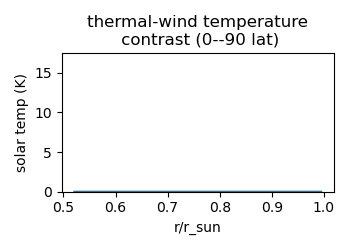

In [35]:
#look at temperature contrast variation with radius
plt.figure(figsize=(3.5, 2.5))
plt.plot(rr/rsun,T_dev2[0,:] - T_dev2[48,:])
plt.xlabel('r/r_sun')
plt.ylabel('solar temp (K)')
plt.title('thermal-wind temperature\n contrast (0--90 lat)')
plt.ylim(0, 17.5)
plt.tight_layout()
plt.savefig('../images/solar_tw_temp_contrast.png')

<IPython.core.display.Javascript object>


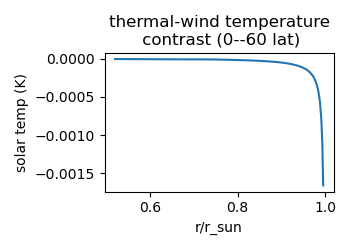

In [36]:
#look at temperature contrast variation with radius
it60 = np.argmin(np.abs(tt - np.pi/6))
plt.figure(figsize=(3.5, 2.5))
plt.plot(rr/rsun, T_dev[it60,:] - T_dev[0,:])
plt.xlabel('r/r_sun')
plt.ylabel('solar temp (K)')
plt.title('thermal-wind temperature\n contrast (0--60 lat)')
#plt.ylim(0, 2)
plt.tight_layout()
plt.savefig('../images/solar_tw_temp_contrast60.png')

<IPython.core.display.Javascript object>


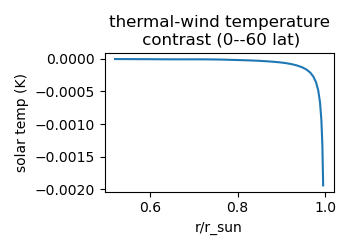

In [37]:
#look at temperature contrast variation with radius
it75 = np.argmin(np.abs(tt - np.pi/12))
plt.figure(figsize=(3.5, 2.5))
plt.plot(rr/rsun, T_dev[it75,:] - T_dev[0,:])
plt.xlabel('r/r_sun')
plt.ylabel('solar temp (K)')
plt.title('thermal-wind temperature\n contrast (0--60 lat)')
#plt.ylim(0, 2)
plt.tight_layout()
plt.savefig('../images/solar_tw_temp_contrast75.png')

In [38]:
tt

array([1.5708   , 1.53807  , 1.50535  , 1.47262  , 1.4399   , 1.40717  ,
       1.37445  , 1.34172  , 1.309    , 1.27627  , 1.24355  , 1.21082  ,
       1.1781   , 1.14537  , 1.11265  , 1.07992  , 1.0472   , 1.01447  ,
       0.981748 , 0.949023 , 0.916298 , 0.883573 , 0.850848 , 0.818123 ,
       0.785398 , 0.752673 , 0.719948 , 0.687223 , 0.654499 , 0.621774 ,
       0.589049 , 0.556324 , 0.523599 , 0.490874 , 0.458149 , 0.425424 ,
       0.392699 , 0.359974 , 0.327249 , 0.294524 , 0.261799 , 0.229074 ,
       0.19635  , 0.163625 , 0.1309   , 0.0981748, 0.0654498, 0.0327249,
       0.       ])

In [39]:
np.shape(T_dev)

(49, 28)

<IPython.core.display.Javascript object>


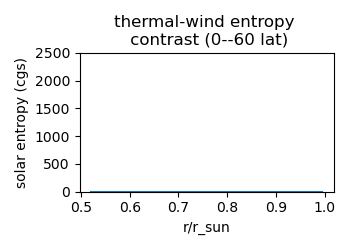

In [40]:
#look at entropy contrast variation with radius
it75 = np.argmin(np.abs(tt - np.pi/12))
plt.figure(figsize=(3.5, 2.5))
plt.plot(rr/rsun, S_dev[it75,:] - S_dev[0,:])
plt.xlabel('r/r_sun')
plt.ylabel('solar entropy (cgs)')
plt.title('thermal-wind entropy \n contrast (0--60 lat)')
plt.ylim(0, 2500)
plt.tight_layout()
#plt.savefig('../images/solar_tw_temp_contrast75.png')

<IPython.core.display.Javascript object>


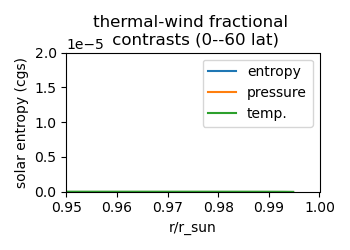

In [41]:
# fractional contrasts (up to 60) for all three thermo variables
itmax = np.argmin(np.abs(tt - np.pi/3))
plt.figure(figsize=(3.5, 2.5))
plt.plot(rr/rsun, (S_dev[itmax,:] - S_dev[0,:])/cp, label='entropy')
plt.plot(rr/rsun, (P_dev[itmax,:] - P_dev[0,:])/prs, label='pressure')
plt.plot(rr/rsun, (T_dev[itmax,:] - T_dev[0,:])/T, label='temp.')
plt.legend()
plt.xlabel('r/r_sun')
plt.ylabel('solar entropy (cgs)')
plt.title('thermal-wind fractional \n contrasts (0--60 lat)')
plt.ylim(0, 2e-5)
plt.xlim(0.95,1)
plt.tight_layout()

<IPython.core.display.Javascript object>


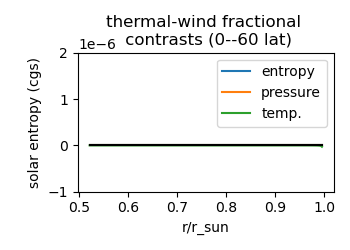

In [42]:
# fractional contrasts (up to 60) for all three thermo variables, full shell
itmax = np.argmin(np.abs(tt - np.pi/3))
plt.figure(figsize=(3.5, 2.5))
plt.plot(rr/rsun, (S_dev[itmax,:] - S_dev[0,:])/cp, label='entropy')
plt.plot(rr/rsun, (P_dev[itmax,:] - P_dev[0,:])/prs, label='pressure')
plt.plot(rr/rsun, (T_dev[itmax,:] - T_dev[0,:])/T, label='temp.')
plt.plot(rr/rsun, np.zeros_like(rr), 'k-')
plt.legend()
plt.xlabel('r/r_sun')
plt.ylabel('solar entropy (cgs)')
plt.title('thermal-wind fractional \n contrasts (0--60 lat)')
plt.ylim(-1e-6, 2e-6)
#plt.xlim(0.95,1)
plt.tight_layout()

In [43]:
len(prs)

28

In [44]:
np.shape(P_dev)

(49, 28)